# Stock-Bot

Decision to buy/sell is made when a certain SMA is crossed.

- get gradiant of all SMAs at that point
- guess price when the stock cross that SMA again

### How?

- when stock cross -> ask experts

In [70]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.metrics import *

pd.options.mode.chained_assignment = None

## Pre-processing

In [90]:
companies_df = pd.read_csv('data/sp500_companies.csv').sort_values(by='Weight', ascending=False)
index_df = pd.read_csv('data/sp500_index.csv')
stocks_df = pd.read_csv('data/sp500_stocks.csv')

### Calculate values for a single company

In [91]:
drop_cols = ['Symbol', 'Adj Close', 'High', 'Low', 'Open', 'Volume']
ma_sizes = [5, 10, 30, 50]
lookahead =  21 # NOTE: in days
num_companies = 450

def create_company_df(symbol: str):
    company_df = stocks_df[stocks_df.Symbol == symbol]
    company_df = company_df.sort_values(by='Date').drop(columns=drop_cols)
    # company_df = company_df.tail(365) # NOTE: gets last year of data
    for size in ma_sizes:
        company_df[f'SMA{size}'] = company_df['Close'].rolling(size).mean()
    company_df.dropna(inplace=True)


    # Calculate SMA gradients
    for size in ma_sizes:
        company_df[f'SMA{size}_diff'] = company_df[f'SMA{size}'] - company_df[f'SMA{size}'].shift(1)
        company_df[f'SMA{size}_angle'] = company_df.apply(lambda row: math.atan(row[f'SMA{size}_diff']), axis=1)

    # NOTE: Calculate Close value in 14 days time
    company_df['future_close'] = company_df['Close'].shift(-lookahead) - company_df['Close']
    company_df.dropna(inplace=True)
    return company_df

    # Plot
    # company_df[['Close', 'SMA5', 'SMA10', 'SMA30', 'SMA50']].plot(label='AAPL', figsize=(12, 4))

### Data prep

In [92]:
df = create_company_df('AAPL')
symbols = list(companies_df.Symbol.unique())
for symbol in symbols[1:num_companies]:
    df = pd.concat((df, create_company_df(symbol)), axis=0, ignore_index=True)

df = df[['Date', 'SMA5_angle', 'SMA10_angle', 'SMA30_angle', 'SMA50_angle', 'future_close', 'Close']].sort_values(by='Date').drop(columns=['Date'])

df['outcome'] = df['future_close'] > 0
df.shape

(1379289, 7)

### Train models

#### Regression

In [93]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['future_close', 'outcome']), df['future_close'], test_size = 0.2)

In [94]:
def print_statistics(regression_model, name):
    print(f'---------- {name} ----------')
    print(f'Max Error: {max_error(y_test, regression_model.predict(X_test))}')
    print(f'MSE:       {mean_squared_error(y_test, regression_model.predict(X_test))}')
    print(f'MAE:       {mean_absolute_error(y_test, regression_model.predict(X_test))}')
    print(f'R2 Score:  {regression_model.score(X_test, y_test)}')

In [95]:
# adaboost = AdaBoostRegressor(n_estimators=50)
# adaboost.fit(X_train, y_train)
# print_statistics(adaboost, 'AdaBoost')

#### Classification

In [96]:
run_results = list()
for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['future_close', 'outcome']), df['outcome'], test_size = 0.2)
    ac = AdaBoostClassifier(n_estimators=40)
    ac.fit(X_train, y_train)
    run_results.append(ac.score(X_test, y_test))

print(f'average: {sum(run_results) / len(run_results)}')

(10) average: 0.5838619869643077
(25) average: 0.5831828936143475
(50) average: 0.5838172779715167
(100) average: 0.5837206098789957


## Optimization

In [50]:
import cify as ci
from cify.si.pso.algorithm import InertiaWeightPSO

def dafunc(vector):
    lookahead = int(vector[0])
    df['future_close'] = df['Close'].shift(-lookahead) - df['Close']
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['future_close', 'outcome']), df['outcome'], test_size = 0.2)
    ac = AdaBoostClassifier(n_estimators=50)
    ac.fit(X_train, y_train)
    return float(ac.score(X_test, y_test))

def vc(vector):
    for x in vector:
        if x > 10 or x < 3:
            return False
    return True

obj_func = ci.ObjectiveFunction(function=dafunc, bounds=[0, 10], vector_constraints=[vc])
# obj_func = ci.get_objective_function('sphere')
print(obj_func)
print(type(obj_func))

Minimization: <function dafunc at 0x2a8dd5630>
Bounds: [[0, 10], [0, 10], [0, 10], [0, 10], [0, 10], [0, 10], [0, 10], [0, 10], [0, 10], [0, 10]]
Vector Constraints: [<function vc at 0x2a8dd5360>]

<class 'cify.core.objective_function.ObjectiveFunction'>


In [51]:
swarm = ci.get_swarm(obj_func=obj_func, n_particles=10)
algo = InertiaWeightPSO(obj_func=obj_func, swarms=[swarm])
# meta.execute(50)
# meta.statistics.tail(3)

In [52]:
algo.execute(20)
algo.statistics.tail(3)

100%|██████████| 20/20 [41:32<00:00, 124.65s/it]


,best,worst,mean,stdev,global_optimum,n_evaluations
iteration,,,,,,
18,0.597809,0.607825,0.601659,0.009755,0.606573,284
19,0.612520,0.625039,0.607324,0.008695,0.606260,284
20,0.596244,0.613772,0.606886,0.006072,0.599687,283


<AxesSubplot: xlabel='iteration', ylabel='mean'>

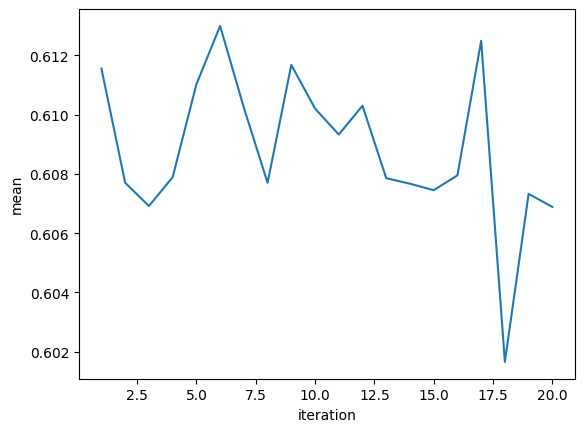

In [58]:
sns.lineplot(data=algo.statistics, x=algo.statistics.index, y='mean')